## Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import pickle
from mlxtend.data import loadlocal_mnist

## Setting Numpy Seed

In [2]:
np.random.seed(10)

## Processing MNIST Dataset

In [3]:
def process_mnist_data() -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    mnist_path = './MNIST/'
    train_images, train_labels = loadlocal_mnist(
        images_path = mnist_path + './train-images.idx3-ubyte',
        labels_path = mnist_path + './train-labels.idx1-ubyte'
    )
    test_images, test_labels = loadlocal_mnist(
        images_path = mnist_path + './t10k-images.idx3-ubyte',
        labels_path = mnist_path + './t10k-labels.idx1-ubyte'
    )
    return train_images, train_labels, test_images, test_labels

## Processing CIFAR-10 Dataset

In [4]:
def unpickle(file):
    with open(file, 'rb') as fo:
        data_dict = pickle.load(fo, encoding='bytes')
    return data_dict

In [5]:
def process_cifar_dataset() -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    cifar_path = './cifar-10-python/cifar-10-batches-py'
    data_batch = unpickle(cifar_path + '/data_batch_1')
    train_images, train_labels = data_batch[b'data'], np.array(data_batch[b'labels'])
    for i in range(2,6):
        data_batch = unpickle(cifar_path + '/data_batch_' + str(i))
        train_images = np.concatenate((train_images, data_batch[b'data']), axis=0)
        train_labels = np.concatenate((train_labels, np.array(data_batch[b'labels'])), axis=0)
    test_batch = unpickle(cifar_path + '/test_batch')
    test_images, test_labels = test_batch[b'data'], np.array(test_batch[b'labels'])
    return train_images, train_labels, test_images, test_labels

## Processing Toy Dataset

In [6]:
def process_toy_dataset():
    toy_dataset_path = './Toy Dataset/'
    a = np.loadtxt(toy_dataset_path + 'trainNN.txt')
    b = np.loadtxt(toy_dataset_path + 'testNN.txt')
    train_x, train_y, test_x, test_y = a[:, 0:4], a[:, -1], b[:, 0:4], b[:, -1]
    return train_x, train_y, test_x, test_y

In [7]:
x_train_toy, y_train_toy, x_test_toy, y_test_toy = process_toy_dataset()
toy_batch_1 = x_train_toy[0:50].reshape(50, 1, 2, 2)
toy_batch_1[0, 0, :, :]

array([[ 9.21323266, 11.82445528],
       [16.69098092, 19.56967227]])

In [8]:
label_binarizer = LabelBinarizer()
label_binarizer.fit(range(1,5))
toy_labels_1 = label_binarizer.transform(y_train_toy[0:50].T)
toy_labels_1

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 1,

## Parsing Input Model

In [9]:
def parse_input_model():
    path = './input_model.txt'
    model = []
    with open(path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            tokens = line.split()
            if tokens[0] == 'Conv':
                model.append(ConvolutionLayerBatch(int(tokens[1]), int(tokens[2]), int(tokens[3]), int(tokens[4])))
            if tokens[0] == 'ReLU':
                model.append(ActivationLayer())
            if tokens[0] == 'Pool':
                model.append(MaxPoolingLayerBatch(int(tokens[1]), int(tokens[2])))
            if tokens[0] == 'FC':
                model.append(FlatteningLayerBatch())
                model.append(FullyConnectedLayerBatch(int(tokens[1])))
            if tokens[0] == 'Softmax':
                model.append(SoftmaxLayerBatch())
        return model

## ReLU and ReLU Derivative Functions

In [10]:
def relu(matrix:np.ndarray) -> np.ndarray:
    return matrix * (matrix > 0)

In [11]:
def relu_derivative(matrix: np.ndarray) -> np.ndarray:
    return (matrix > 0) * 1.0

## Convolution Layer

In [12]:
class ConvolutionLayer:
    def __init__(self, output_channel_count: int, filter_dimension: int, stride: int, padding: int):
        self.output_channel_count = output_channel_count
        self.filter_dimension = filter_dimension
        self.stride = stride
        self.padding = padding

    def forward(self, input_image: np.ndarray) -> np.ndarray:
        input_dimentions = input_image.shape[0]
        output_dimentions = (input_dimentions - self.filter_dimension + 2 * self.padding) // self.stride + 1
        input_shape = input_image.shape

        filters = np.random.rand(
            self.output_channel_count,
            self.filter_dimension,
            self.filter_dimension,
            input_shape[2]
        )

        bias = np.random.rand(self.output_channel_count)

        padded_image = np.pad(input_image, [(self.padding,self.padding), (self.padding,self.padding), (0,0)], mode='constant') * 1.0
        padded_image /= 255.0
        padded_dimensions = padded_image.shape

        output = np.zeros((output_dimentions, output_dimentions, self.output_channel_count))

        image_y = out_y = 0
        while image_y + self.filter_dimension <= padded_dimensions[1]:
            image_x = out_x = 0
            while image_x + self.filter_dimension <= padded_dimensions[0]:
                image_slice = padded_image[image_x:image_x+self.filter_dimension, image_y:image_y+self.filter_dimension, :]
                output[out_x, out_y, :] = np.sum(image_slice * filters) + bias
                image_x += self.stride
                out_x += 1
            image_y += self.stride
            out_y += 1

        return output

    def backward(self):
        pass

In [13]:
class ConvolutionLayerBatch:
    def __init__(self, output_channel_count: int, filter_dimension: int, stride: int, padding: int):
        self.output_channel_count = output_channel_count
        self.filter_dimension = filter_dimension
        self.stride = stride
        self.padding = padding
        self.bias = None
        self.filters = None
        self.input_batch = None

    def forward(self, input_batch: np.ndarray) -> np.ndarray:
        self.input_batch = input_batch

        input_dimentions = input_batch.shape
        output_dimentions = (input_dimentions[2] - self.filter_dimension + 2 * self.padding) // self.stride + 1
        input_shape = input_batch.shape

        if self.filters is None:
            self.filters = np.random.rand(
                self.output_channel_count,
                input_shape[1],
                self.filter_dimension,
                self.filter_dimension
            ) * 0.001

        if self.bias is None:
            self.bias = np.random.rand(self.output_channel_count) * 0.001

        padded_image = np.pad(input_batch, [(0, 0), (0, 0), (self.padding,self.padding), (self.padding,self.padding)], mode='constant') * 1.0
        padded_image /= 255.0
        padded_dimensions = padded_image.shape

        output = np.zeros((input_dimentions[0], self.output_channel_count, output_dimentions, output_dimentions))

        for i in range(input_dimentions[0]):
            image_y = out_y = 0
            while image_y + self.filter_dimension <= padded_dimensions[3]:
                image_x = out_x = 0
                while image_x + self.filter_dimension <= padded_dimensions[2]:
                    image_slice = padded_image[i, :, image_x:image_x+self.filter_dimension, image_y:image_y+self.filter_dimension]
                    output[i, :, out_x, out_y] = np.sum(image_slice * self.filters) + self.bias
                    image_x += self.stride
                    out_x += 1
                image_y += self.stride
                out_y += 1

        return output

    def backward(self, dz: np.ndarray, learning_rate:float = 0.01) -> np.ndarray:
        batch_size = dz.shape[0]
        db = np.sum(dz, axis=(0, 2, 3))
        self.bias = self.bias - learning_rate * db / batch_size
        padded_image = np.pad(self.input_batch, [(0, 0), (0, 0), (self.padding,self.padding), (self.padding,self.padding)], mode='constant') * 1.0
        padded_dimensions = padded_image.shape

        dw = np.zeros(self.filters.shape)
        dout_padded = np.zeros(padded_dimensions)
        filter_shape = self.filters.shape

        for i in range(batch_size):
            tmp_y = out_y = 0
            while tmp_y + self.filter_dimension <= padded_dimensions[3]:
                tmp_x = out_x = 0
                while tmp_x + self.filter_dimension <= padded_dimensions[2]:
                    image_slice = padded_image[i, :, tmp_x: tmp_x+self.filter_dimension, tmp_y:tmp_y+self.filter_dimension]
                    # dw += np.sum(dz[i, :, out_x, out_y].reshape(self.output_channel_count, 1, 1) * image_slice)
                    # dout_padded[i, :, tmp_x: tmp_x+self.filter_dimension, tmp_y:tmp_y+self.filter_dimension] += np.sum(np.broadcast_to(dz[i, :, out_x, out_y].reshape(self.output_channel_count, padded_dimensions[1], 1, 1), filter_shape) * self.filters, axis=0)
                    for f in range(self.output_channel_count):
                        dout_padded[i, :, tmp_x: tmp_x+self.filter_dimension, tmp_y:tmp_y+self.filter_dimension] += dz[i, f, out_x, out_y] * self.filters[f, :, :, :]
                    tmp_x += self.stride
                    out_x += 1
                tmp_y += self.stride
                out_y += 1

        self.filters -= learning_rate * dw
        return dout_padded[:, :, self.padding:padded_dimensions[2]-self.padding, self.padding:padded_dimensions[3]-self.padding]

In [14]:
test_conv = ConvolutionLayerBatch(4, 2, 2, 2)
test_conv_out = test_conv.forward(toy_batch_1)
test_conv_out.shape

(50, 4, 3, 3)

In [15]:
test_conv_out[0, 0, :, :]

array([[0.00072176, 0.00072176, 0.00072176],
       [0.00072176, 0.00120162, 0.00072176],
       [0.00072176, 0.00072176, 0.00072176]])

## Activation Layer

In [16]:
class ActivationLayer:
    def __init__(self):
        pass

    @staticmethod
    def forward(input_matrix: np.ndarray) -> np.ndarray:
        return relu(input_matrix)

    @staticmethod
    def backward(input_matrix: np.ndarray) -> np.ndarray:
        return input_matrix * relu_derivative(input_matrix)

In [17]:
test_activation = ActivationLayer()
test_activation_out = test_activation.forward(test_conv_out)
test_activation_out.shape

(50, 4, 3, 3)

In [18]:
test_activation_out[0, 0, :, :]

array([[0.00072176, 0.00072176, 0.00072176],
       [0.00072176, 0.00120162, 0.00072176],
       [0.00072176, 0.00072176, 0.00072176]])

## Max Pooling Layer

In [19]:
class MaxPoolingLayer:
    def __init__(self, filter_dimension: int, stride: int):
        self.filter_dimension = filter_dimension
        self.stride = stride

    def forward(self, image: np.ndarray) -> np.ndarray:
        input_dimensions = image.shape
        output_dimension = (input_dimensions[0] - self.filter_dimension) // self.stride + 1

        output = np.zeros((output_dimension, output_dimension, input_dimensions[2]))

        image_y = out_y = 0
        while image_y + self.filter_dimension <= input_dimensions[1]:
            image_x = out_x = 0
            while image_x + self.filter_dimension <= input_dimensions[0]:
                image_slice = image[image_x: image_x+self.filter_dimension, image_y: image_y+self.filter_dimension, :]
                output[out_x, out_y, :] = np.max(image_slice, axis=(0, 1))
                image_x += self.stride
                out_x += 1
            image_y += self.stride
            out_y += 1

        return output

    def backward(self):
        pass

In [20]:
class MaxPoolingLayerBatch:
    def __init__(self, filter_dimension: int, stride: int):
        self.filter_dimension = filter_dimension
        self.stride = stride
        self.mask = None
        self.input_dimensions = None

    def forward(self, image: np.ndarray) -> np.ndarray:
        input_dimensions = image.shape
        self.input_dimensions = input_dimensions
        output_dimension = (input_dimensions[2] - self.filter_dimension) // self.stride + 1

        output = np.zeros((input_dimensions[0], input_dimensions[1], output_dimension, output_dimension))
        self.mask = np.zeros(input_dimensions)

        for i in range(input_dimensions[0]):
            image_y = out_y = 0
            while image_y + self.filter_dimension <= input_dimensions[3]:
                image_x = out_x = 0
                while image_x + self.filter_dimension <= input_dimensions[2]:
                    image_slice = image[i, :, image_x: image_x+self.filter_dimension, image_y: image_y+self.filter_dimension]
                    max_val = np.max(image_slice, axis=(1, 2))
                    output[i, :, out_x, out_y] = max_val
                    self.mask[i, :, image_x: image_x+self.filter_dimension, image_y: image_y+self.filter_dimension] = image_slice == max_val.reshape(input_dimensions[1], 1, 1)
                    image_x += self.stride
                    out_x += 1
                image_y += self.stride
                out_y += 1

        return output

    def backward(self, dh:np.ndarray) -> np.ndarray:
        output = np.zeros(self.input_dimensions)

        for i in range(self.input_dimensions[0]):
            out_y = dh_y = 0
            while out_y + self.filter_dimension <= self.input_dimensions[3]:
                out_x = dh_x = 0
                while out_x + self.filter_dimension <= self.input_dimensions[2]:
                    mask_patch = self.mask[i, :, out_x: out_x+self.filter_dimension, out_y: out_y+self.filter_dimension]
                    output[i, :, out_x: out_x+self.filter_dimension, out_y: out_y+self.filter_dimension] += mask_patch * dh[i, :, dh_x, dh_y].reshape(self.input_dimensions[1], 1, 1)
                    out_x += self.stride
                    dh_x += 1
                out_y += self.stride
                dh_y += 1

        return output

In [21]:
test_maxpool = MaxPoolingLayerBatch(2, 1)
test_maxpool_out = test_maxpool.forward(test_activation_out)
test_maxpool_out.shape

(50, 4, 2, 2)

In [22]:
test_maxpool_out[0, 0, :, :]

array([[0.00120162, 0.00120162],
       [0.00120162, 0.00120162]])

## Flattening Layer

In [23]:
class FlatteningLayer:
    def __init__(self):
        pass

    @staticmethod
    def forward(image: np.ndarray) -> np.ndarray:
        return image.flatten().reshape(-1, 1)

    def backward(self):
        pass

In [24]:
class FlatteningLayerBatch:
    def __init__(self):
        self.input_shape = None

    def forward(self, input_batch: np.ndarray) -> np.ndarray:
        input_shape = input_batch.shape
        self.input_shape = input_shape
        return input_batch.reshape((input_shape[0], -1))

    def backward(self, dh_flattened: np.ndarray) -> np.ndarray:
        return dh_flattened.reshape(self.input_shape)

In [25]:
test_flattening = FlatteningLayerBatch()
test_flattening_out = test_flattening.forward(test_maxpool_out)
test_flattening_out.shape

(50, 16)

In [26]:
test_flattening_out

array([[0.00120162, 0.00120162, 0.00120162, 0.00120162, 0.00077174,
        0.00077174, 0.00077174, 0.00077174, 0.00139764, 0.00139764,
        0.00139764, 0.00139764, 0.00119444, 0.00119444, 0.00119444,
        0.00119444],
       [0.00166546, 0.00166546, 0.00166546, 0.00166546, 0.00123558,
        0.00123558, 0.00123558, 0.00123558, 0.00186148, 0.00186148,
        0.00186148, 0.00186148, 0.00165828, 0.00165828, 0.00165828,
        0.00165828],
       [0.00260606, 0.00260606, 0.00260606, 0.00260606, 0.00217618,
        0.00217618, 0.00217618, 0.00217618, 0.00280208, 0.00280208,
        0.00280208, 0.00280208, 0.00259888, 0.00259888, 0.00259888,
        0.00259888],
       [0.00213731, 0.00213731, 0.00213731, 0.00213731, 0.00170743,
        0.00170743, 0.00170743, 0.00170743, 0.00233333, 0.00233333,
        0.00233333, 0.00233333, 0.00213013, 0.00213013, 0.00213013,
        0.00213013],
       [0.00260565, 0.00260565, 0.00260565, 0.00260565, 0.00217577,
        0.00217577, 0.00217577, 

## Fully Connected Layer

In [27]:
class FullyConnectedLayer:
    def __init__(self, output_dimension: int):
        self.output_dimension = output_dimension

    def forward(self, flattened_input: np.ndarray) -> np.ndarray:
        weights = np.random.rand(flattened_input.shape[0], self.output_dimension)
        bias = np.random.rand(self.output_dimension, 1)

        return weights.T @ flattened_input + bias

    def backward(self):
        pass

In [28]:
class FullyConnectedLayerBatch:
    def __init__(self, output_dimension: int):
        self.output_dimension = output_dimension
        self.input_matrix = None
        self.weights = None
        self.bias = None

    def forward(self, flattened_input: np.ndarray) -> np.ndarray:
        if self.weights is None:
            self.weights = np.random.rand(flattened_input.shape[1], self.output_dimension) * 0.001
        if self.bias is None:
            self.bias = np.random.rand(1, self.output_dimension) * 0.001
        self.input_matrix = flattened_input

        return flattened_input @ self.weights + self.bias

    def backward(self, d_theta: np.ndarray, learning_rate: float = 0.01) -> np.ndarray:
        n = d_theta.shape[0]
        dw = self.input_matrix.T @ d_theta
        db = np.sum(d_theta, axis=0, keepdims=True)
        dh = d_theta @ self.weights.T
        self.weights = self.weights - learning_rate * dw / n
        self.bias = self.bias - learning_rate * db / n

        return dh

In [29]:
test_fc = FullyConnectedLayerBatch(4)
test_fc_out = test_fc.forward(test_flattening_out)
test_fc_out.shape

(50, 4)

In [30]:
test_fc_out

array([[3.10923949e-04, 3.49990193e-05, 3.10825007e-04, 2.50688790e-04],
       [3.14847440e-04, 3.89966825e-05, 3.13843585e-04, 2.54266757e-04],
       [3.22803722e-04, 4.71033748e-05, 3.19964831e-04, 2.61522366e-04],
       [3.18838660e-04, 4.30633552e-05, 3.16914271e-04, 2.57906489e-04],
       [3.22800190e-04, 4.70997763e-05, 3.19962114e-04, 2.61519145e-04],
       [3.14786446e-04, 3.89345353e-05, 3.13796658e-04, 2.54211135e-04],
       [3.10801949e-04, 3.48747132e-05, 3.10731145e-04, 2.50577535e-04],
       [3.18896228e-04, 4.31220114e-05, 3.16958561e-04, 2.57958987e-04],
       [3.10834034e-04, 3.49074045e-05, 3.10755830e-04, 2.50606794e-04],
       [3.18846084e-04, 4.30709193e-05, 3.16919982e-04, 2.57913259e-04],
       [3.18786412e-04, 4.30101193e-05, 3.16874073e-04, 2.57858842e-04],
       [3.18867477e-04, 4.30927162e-05, 3.16936441e-04, 2.57932768e-04],
       [3.18884132e-04, 4.31096867e-05, 3.16949255e-04, 2.57947956e-04],
       [3.14733898e-04, 3.88809943e-05, 3.13756230e

## Softmax Layer

In [31]:
class SoftmaxLayer:
    def __init__(self):
        pass

    @staticmethod
    def forward(input_matrix: np.ndarray) -> np.ndarray:
        exp = np.exp(input_matrix)
        exp /= np.sum(exp)
        return exp

    def backward(self):
        pass

In [32]:
class SoftmaxLayerBatch:
    def __init__(self):
        self.y_hat = None

    def forward(self, input_matrix: np.ndarray) -> np.ndarray:
        exp = np.exp(input_matrix)
        exp_sum = np.sum(exp, axis=1).reshape(-1, 1)
        exp /= exp_sum
        self.y_hat = exp
        return exp

    def backward(self, y: np.ndarray) -> np.ndarray:
        return self.y_hat - y

In [33]:
test_softmax = SoftmaxLayerBatch()
test_softmax_out = test_softmax.forward(test_fc_out)
test_softmax_out.shape

(50, 4)

In [34]:
test_softmax_out

array([[0.25002102, 0.24995204, 0.25002099, 0.25000596],
       [0.25002109, 0.24995213, 0.25002084, 0.25000594],
       [0.25002124, 0.24995232, 0.25002053, 0.25000592],
       [0.25002116, 0.24995222, 0.25002068, 0.25000593],
       [0.25002124, 0.24995232, 0.25002053, 0.25000592],
       [0.25002109, 0.24995213, 0.25002084, 0.25000594],
       [0.25002101, 0.24995204, 0.250021  , 0.25000596],
       [0.25002116, 0.24995222, 0.25002068, 0.25000593],
       [0.25002101, 0.24995204, 0.25002099, 0.25000596],
       [0.25002116, 0.24995222, 0.25002068, 0.25000593],
       [0.25002116, 0.24995222, 0.25002068, 0.25000593],
       [0.25002116, 0.24995222, 0.25002068, 0.25000593],
       [0.25002116, 0.24995222, 0.25002068, 0.25000593],
       [0.25002109, 0.24995213, 0.25002084, 0.25000594],
       [0.25002101, 0.24995203, 0.250021  , 0.25000596],
       [0.25002109, 0.24995213, 0.25002084, 0.25000594],
       [0.25002101, 0.24995204, 0.25002099, 0.25000596],
       [0.25002117, 0.24995223,

## Backprop Test

#### Loss Function

In [35]:
def loss_function(y_true, y_pred):
    labels = y_true * np.log(y_pred) * -1.0
    return np.sum(labels) / y_true.shape[0]

In [36]:
loss_function_test = loss_function(toy_labels_1, test_softmax_out)
loss_function_test

1.3862649577055566

#### Softmax Layer

In [37]:
test_softmax_back = test_softmax.backward(toy_labels_1)
print(test_softmax_back.shape)
test_softmax_back

(50, 4)


array([[-0.74997898,  0.24995204,  0.25002099,  0.25000596],
       [ 0.25002109, -0.75004787,  0.25002084,  0.25000594],
       [ 0.25002124,  0.24995232,  0.25002053, -0.74999408],
       [ 0.25002116,  0.24995222, -0.74997932,  0.25000593],
       [ 0.25002124,  0.24995232,  0.25002053, -0.74999408],
       [ 0.25002109, -0.75004787,  0.25002084,  0.25000594],
       [-0.74997899,  0.24995204,  0.250021  ,  0.25000596],
       [ 0.25002116,  0.24995222, -0.74997932,  0.25000593],
       [-0.74997899,  0.24995204,  0.25002099,  0.25000596],
       [ 0.25002116,  0.24995222, -0.74997932,  0.25000593],
       [ 0.25002116,  0.24995222, -0.74997932,  0.25000593],
       [ 0.25002116,  0.24995222, -0.74997932,  0.25000593],
       [ 0.25002116,  0.24995222, -0.74997932,  0.25000593],
       [ 0.25002109, -0.75004787,  0.25002084,  0.25000594],
       [-0.74997899,  0.24995203,  0.250021  ,  0.25000596],
       [ 0.25002109, -0.75004787,  0.25002084,  0.25000594],
       [-0.74997899,  0.

#### Fully Connected Layer

In [38]:
test_fc_back = test_fc.backward(test_softmax_back, learning_rate=0.01)
print(test_fc_back.shape)
test_fc_back

(50, 16)


array([[-1.09480736e-04,  5.98594155e-05, -5.81571038e-06,
        -5.03880313e-04,  2.89945292e-04,  5.80630849e-05,
         2.19879663e-04, -8.13746269e-05, -2.45923755e-04,
        -3.57251017e-04,  5.88530202e-05,  1.56089551e-04,
         6.27541693e-05,  2.02723761e-05, -1.45221984e-04,
        -1.10801229e-04],
       [ 2.90893572e-04,  6.76785680e-05,  4.35424916e-05,
         8.55325576e-05, -4.24751603e-04, -2.13637681e-04,
        -1.83115351e-04,  7.91210912e-05,  4.24029887e-04,
         1.74069896e-04, -2.46607054e-04, -1.61810421e-04,
        -3.80356731e-04, -3.01291867e-04, -2.85474008e-05,
        -1.86902947e-05],
       [-2.41070021e-04, -1.14457390e-05,  1.22934239e-04,
         1.04068749e-04, -2.22357284e-04, -2.51200837e-04,
        -3.12404060e-04,  1.50676570e-04, -3.69078799e-04,
         3.79000279e-04,  6.60234199e-05, -1.10088540e-04,
        -3.60184430e-05,  2.92101977e-04,  3.17184033e-04,
         2.32560666e-04],
       [ 5.97228468e-05, -1.16074446e

#### Flattening Layer

In [39]:
test_flattening_back = test_flattening.backward(test_fc_back)
test_flattening_back[0, 0, :, :]

array([[-1.09480736e-04,  5.98594155e-05],
       [-5.81571038e-06, -5.03880313e-04]])

#### MaxPooling Layer

In [40]:
test_maxpool_back = test_maxpool.backward(test_flattening_back)
test_flattening_back.shape

(50, 4, 2, 2)

In [41]:
test_maxpool_back[0, 0, :, :]

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        , -0.00055932,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])

#### Activation Layer

In [42]:
test_activation_back = test_activation.backward(test_maxpool_back)
test_activation_back.shape

(50, 4, 3, 3)

In [43]:
test_activation_back[0, 0, :, :]

array([[ 0.,  0.,  0.],
       [ 0., -0.,  0.],
       [ 0.,  0.,  0.]])

#### Convolution Layer

In [44]:
test_conv_back = test_conv.backward(test_activation_back, learning_rate=0.01)
test_conv_back.shape

(50, 1, 2, 2)

In [45]:
test_conv_back[0, 0, :, :]

array([[2.42530348e-07, 1.09366583e-07],
       [9.63602402e-08, 3.70008392e-07]])

## Main Test

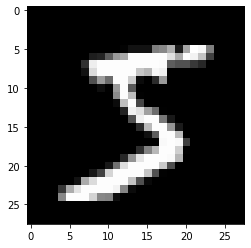

In [46]:
x_train, y_train, x_test, y_test = process_mnist_data()
img = x_train[0].reshape(28, 28, 1)
plt.imshow(img, cmap='gray')

In [47]:
model = parse_input_model()
mnist_batch_1 = x_train[0:64].reshape(64, 1, 28, 28)
mnist_batch_1.shape

(64, 1, 28, 28)

In [48]:
# train
mnist_subsample_x = x_train[:9984]
mnist_subsample_y = y_train[:9984]
# validation
mnist_validation_x = x_test[:5000]
mnist_validation_y = y_test[:5000]
# test
mnist_test_x = x_test[5001:]
mnist_test_y = y_test[5001:]

In [49]:
label_binarizer = LabelBinarizer()
label_binarizer.fit(range(0,10))
for i in range(10):
    for j in range(0, 9984, 64):
        batch_x = mnist_subsample_x[j:j+64].reshape(64, 1, 28, 28)
        batch_y = mnist_subsample_y[j:j+64]
        model_out = batch_x
        for layer in model:
            # print(layer)
            model_out = layer.forward(model_out)
            # print(model_out.shape)

        true_labels = label_binarizer.transform(batch_y)
        l = loss_function(true_labels, model_out)
        print("Epoc {} batch {} loss = {}".format(i, j//64, l))

        model_back = true_labels
        for layer in reversed(model):
            # print(layer)
            model_back = layer.backward(model_back)
            # print(model_back.shape)

Epoc 0 batch 0 loss = 2.302532296198772
Epoc 0 batch 1 loss = 2.3025858864948385
Epoc 0 batch 2 loss = 2.302648214453312
Epoc 0 batch 3 loss = 2.3024853203457747
Epoc 0 batch 4 loss = 2.302640144174545
Epoc 0 batch 5 loss = 2.3024702054266513
Epoc 0 batch 6 loss = 2.3025440658683465
Epoc 0 batch 7 loss = 2.302467885284111
Epoc 0 batch 8 loss = 2.3026356350740254
Epoc 0 batch 9 loss = 2.3025587321837917
Epoc 0 batch 10 loss = 2.3026059158003456
Epoc 0 batch 11 loss = 2.302789039378776
Epoc 0 batch 12 loss = 2.3026724927579707
Epoc 0 batch 13 loss = 2.3026834226779
Epoc 0 batch 14 loss = 2.302521746670356
Epoc 0 batch 15 loss = 2.3023209063146997
Epoc 0 batch 16 loss = 2.3023117386542533
Epoc 0 batch 17 loss = 2.302566159987611
Epoc 0 batch 18 loss = 2.302169001902477
Epoc 0 batch 19 loss = 2.302492605349512
Epoc 0 batch 20 loss = 2.302657510111539



KeyboardInterrupt

